# 使用预训练好的词嵌入（GloVe）完成 IMDB 电影评论情感预测任务

TensorFlow 2.0 + Keras API

In [1]:
import numpy as np
import tensorflow as tf

## IMDB 原始数据集

这里不使用 Keras 内置的 IMDB dataset，内置的数据集已经预先分好词了。这里下载原始数据，然后手动分词。

下载 IMDB 数据集的原数据：[http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/)

### 处理原始数据的标签

In [2]:
import os

imdb_dir = '../../dataset/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
# 看一下处理后的数据结构；一个评论对应一个标签
print("labels type: ", type(labels))
print("labels example: ", labels[0])
print("texts type: ", type(texts))
print("texts example: ", texts[0])

labels type:  <class 'list'>
labels example:  0
texts type:  <class 'list'>
texts example:  Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.


### 对数据进行分词

因为预训练词嵌入特别适合训练数据很少的问题，否则针对具体任务的嵌入可能效果更好。本笔记是介绍使用预训练数据，所以我们假设训练数据比较少，这里我们只取 200 个训练数据。

In [4]:
maxlen = 100  # 100 个单词后截断评论
training_samples = 200  # 训练 200 个样本
validation_samples = 10000  # 在 10000 样本上验证
max_words = 10000  # 只考虑数据集中前 10000 个最常见的单词

# 分词器
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# 将数据划分为训练集和验证集，但首先要打乱数据，因为一开始数据中的样本是排好序的
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


## 下载 GloVe 预训练词嵌入数据

预训练好的数据下载地址：[glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip)

In [5]:
glove_path = '../../dataset/glove.6B/glove.6B.100d.txt'

embeddings_index = {}
f = open(glove_path, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## 定义模型

### 准备 GloVe 词嵌入矩阵

In [6]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # embedding_index will 中未找到的词嵌入向量为 0
            embedding_matrix[i] = embedding_vector

### 定义模型

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

### 在模型中加载 GloVe 词嵌入

In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # 冻结 Embedding 层，训练期间不更新 Embedding 层

## 模型训练和评估

In [11]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

# 保存
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 4s 18ms/sample - loss: 1.5115 - acc: 0.4500 - val_loss: 0.6904 - val_acc: 0.5372
Epoch 2/10
200/200 [==============================] - 2s 9ms/sample - loss: 0.6398 - acc: 0.6150 - val_loss: 0.7459 - val_acc: 0.5014
Epoch 3/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.6230 - acc: 0.6600 - val_loss: 0.9001 - val_acc: 0.5008
Epoch 4/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.4729 - acc: 0.8250 - val_loss: 0.8030 - val_acc: 0.5076
Epoch 5/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.3746 - acc: 0.8750 - val_loss: 0.6756 - val_acc: 0.5826
Epoch 6/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.2685 - acc: 0.9750 - val_loss: 0.8195 - val_acc: 0.5287
Epoch 7/10
200/200 [==============================] - 2s 8ms/sample - loss: 0.3415 - acc: 0.8700 - val_loss: 0.8712 - val_acc: 0.5249
Epoch 8/10
20

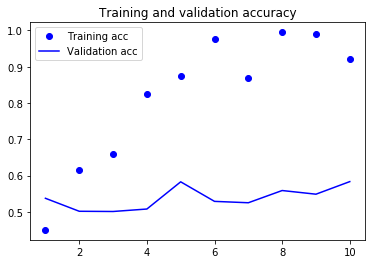

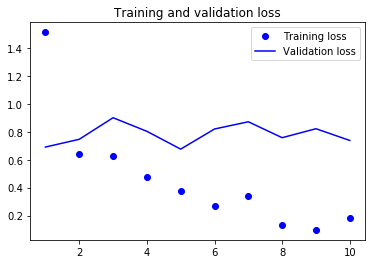

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 模型测试

In [13]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [14]:
# 加载保存的模型
model.load_weights('pre_trained_glove_model.h5')

model.evaluate(x_test, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.7519128960895538, 0.57172]

最后结果测试精度只有 57%。小数据处理起来比较麻烦。